In [1]:
# Imports to get and work with files
import os
import csv

# Standard DS 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Image analysis
import cv2
from PIL import Image

### There are 4 Steps to building our CBIR System
1. Define our image descriptor --> are we interested in color, shape, texture, etc?
2. Index our images --> apply chosen descriptor to each image, extract features, write these features to storage.
3. Define our similarity metric --> popular choices are Euclidean, Cosine, chi-squared, etc. We have had some success with Minkowski
4. Searching / output --> we will eventually be building a way for a user to submit a query and get results. FOR NOW, we will create a pairwise matrix of distances for our researchers to validate during testing.

### Color Descriptor and Histogram / Image Vector

In [2]:
class ColorDescriptors:
    def __init__(self, bins):
        """
        Set the number of bins needed for the 3D Hue-Saturation-Value histogram
        
        ----------
        Paramaters
        ----------
        bins   : tuple of ints representing the number of Hue, Saturation, and Value bins
        
        return : doesn't not return anything
        """
        
        # set the number of histogram bins
        self.bins = bins
        
        
    def describe(self, image):
        """
        Convert provided image into feature vector.
        
        1. convert image to HSV color space
        2. initalize the features vector
        3. determin image size and center
        4. create image masks so image can be scanned in sections
        5. loop over segments to build histogram
        6. return histogram / features vector as image vector
        
        ----------
        Paramaters
        ----------
        image  : ndarry representing an image.
        
        return : list of floating point numbers, an n-dimensional vector 
                 where n = number of bins * number of segments. 
        """
        
        # convert the image to the HSV color space and initialize 
        # the features used to quantify the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
        
        # get the dimensionsand center of the image
        (h, w) = image.shape[:2]
        (cX, cY) = (int(w*0.5), int(h*0.5))
        
        # split image into segmments, this will allow us to simulate
        # locality in a color distribution
        # Divide into 5 segments, top-left, top-right, bottom-left, 
        # bottom-right, and center
        segments = [ (0, cX, 0, cY), (cX, w, 0, cY), 
                     (cX, w, cY, h), (0, cX, cY, h) ]
        
        # create an elliptical mask for the center segment
        (axesX, axesY) = (int(w*0.75) // 2, int(h*0.75) //2)
        ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
        cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
        
        # loop over the segments
        for (startX, endX, startY, endY) in segments:
            # create the mask for each corner subtracting the elliptical center
            cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)
            
            # extract a color histogram from the image under the mask and update features
            hist = self.histogram(image, cornerMask)
            features.extend(hist)
            
        # extract a color histogram from the elliptical region and update features
        hist = self.histogram(image, ellipMask)
        features.extend(hist)
        
        # return the feature vector
        return features
        
        
    def histogram(self, image, mask):
        """
        Extract a 3D histogram from the masked region of an image.
        
        ----------
        Parameters
        ----------
        image  : ndarray representing an image
        mask   : ndarray representing a masked region
        
        return : list of floating point numbers, n-dimensional vector representing
                 the values of the HSV histogram for the masked image segment
        """
        
        # extract a 3D color histogram from the masked region of the image,
        # use the supplied number of bins
        hist = cv2.calcHist( [image], [0, 1, 2], mask, self.bins,
                             [0, 180, 0, 256, 0, 256] )
        
        # normalize the histogram
        hist = cv2.normalize(hist, hist).flatten()
        
        # return the histogram
        return hist
    
        

### Test Color Descriptor and getting an Image Vector

In [3]:
# set bins for Hue, Saturation, and Value
bins = (8, 12, 3)

# initalize the color descriptor
cd = ColorDescriptors(bins)

In [4]:
# set path to image we want to open
img_f_name = 'Paintings/1947.001.png'

# read the image
img = cv2.imread(img_f_name)

# get the features for the image
features = cd.describe(img)

In [5]:
"""
There are 8 hue bins, 12 saturation bins, and 3 value bins so the histogram for each segment should be (8 * 12 * 3) = 288 bins

There are 5 segments so the total feature vector length should be 288 * 5 = 1440
"""

assert len(features) == 8*12*3*5

In [6]:
# print out the first 5 values in features
features[:5]

[0.010591509, 0.015700353, 0.032584466, 0.018566292, 0.040683854]

### loop through images, create image vectors, save output

In [7]:
class ImageSearchUtils:
    """
    Class for utilites, helper functions, and preprocessing / cleaning functions used in the
    Image search engine project
    """
    
    def get_image_file_names(dir_path, make_a_id=False):
        """
        Go to specified directory, find all image/.png files, add them to a list and return that list of names.

        If make_a_id is True, create a_id using image file name to match id's used in other areas of the business
        e.g. change '1980.001.png' to 'a1980_001'

        ----------
        Parameters
        ----------
        dir_path: string, directory path to look through.

        return: list, list of strings of file names.
        """

        # set up empty list which will hold file names
        image_name_list = []

        # loop though directory, check to see if the file is a png and if so add to list
        for file in os.listdir(dir_path):
            # check to see if the file is a .png
            if file.endswith('png'):
                # check to see if make_a_id is True and the file name needs to be changed
                if make_a_id:
                        image_name_list.append('a'+file.replace('.', '_')[:-4])
                # if make_a_id is False get .png file name and add it to list
                else:        
                    image_name_list.append(file)

        # return list of image file names
        return image_name_list



In [8]:
# set path / directory variable to where images are
path = 'Paintings'

# get a list of image file names and a_id names
# .png file names
img_f_names = ImageSearchUtils.get_image_file_names(path)
# a_id formated names
aid_list = ImageSearchUtils.get_image_file_names(path, make_a_id=True)

### Use image file name list and id list to loop through images, create histograms, and add id's with image feature vectors to a list to be saved

In [9]:
# open output file for writing
output = open('image_features.csv', 'w')

# loop over both image file names and ID's
for image_path, a_id in zip(img_f_names, aid_list):
    # set the image ID
    image_id = a_id
    # read the image
    image = cv2.imread(path + '/' + image_path)
    
    # get image features / image vector
    image_features = cd.describe(image)
    
    # write ID and features to the file
    features = [str(f) for f in image_features]
    output.write("%s, %s\n" % (image_id, ",".join(features)))

# close the output file
output.close()


### Image Searcher and Similarty Ranking

In [53]:
class SimilarityRanking:
    def __init__(self, indexPath):
        """
        Set directory path for the file of image vectors.
        
        ----------
        Parameters
        ----------
        indexPath : srting, directory path to image vectors.
        
        return    : Doesn't return anythin just sets the indexPath variable
        """
        # set the indexPath to where the image vector file is
        self.indexPath = indexPath
        
        
    def search(self, queryFeatures, metric = 'chi-squared', limit = 10):
        """
        
        """
        
        # initialize results dictionary
        results = {}
        
        # open the file to read image vectors
        with open(self.indexPath) as f:
            # initiate the CSV reader
            reader = csv.reader(f)
            
            # loop over the rows
            for row in reader:
                # parse out the image ID and feature vector, then compute
                # the distance between features in our file and the image
                # being queried
                features = [float(x) for x in row[1:]]
                
                # calculate the distance from the image and the query image
                # default chi-squared but user can choose between those below
                if metric == 'chi-squared':
                    dist = self.chi2_distance(features, queryFeatures)
                elif metric == 'euclidean':
                    pass
                elif metric == 'cosine':
                    pass
                elif metric == 'minkowski':
                    pass
                
                # once we have the distance, upadte results dictionary using
                # the image ID as the key and the distance as the value, the
                # distance represents similar of the image to the query image
                results[row[0]] = dist
                
            # close the reader
            f.close
            
        # sort the results smallest to largest
        results = sorted( [(v, k) for (k, v) in results.items()] )
        
        # return the results limited by limit parameter
        return results[1:limit]
                
    
    def chi2_distance(self, histA, histB, eps = 1e-10):
        """
        
        """
        
        # compute the chi-squared distance
        dist = 0.5 * np.sum( [ ((a - b) ** 2) / (a + b + eps) 
                              for (a, b) in zip(histA, histB) ] )
        
        # return the chi-squared distance
        return dist
        
        

### Test Image Search by Color Descriptor

In [142]:
# initialize our image descriptor
cd = ColorDescriptors((8, 12, 3))

In [164]:
# set an image to query
query = cv2.imread('Paintings/1983.001.png')
features = cd.describe(query)

In [165]:
# perform the search
searcher = SimilarityRanking('image_features.csv')
results = searcher.search(features)

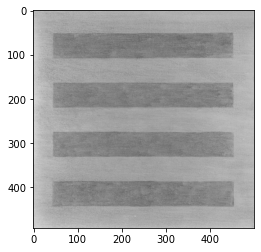

In [166]:
img = Image.open('Paintings/1983.001.png')
plt.imshow(img);

In [167]:
results

[(0.5732986643343321, 'a1983_008'),
 (1.463307427411314, 'a1989_018'),
 (1.9384967020818562, 'a1990_006'),
 (2.1165054944638464, 'a1983_003'),
 (2.2043870526813714, 'a1989_015'),
 (2.3160676782614518, 'a1988_003'),
 (2.4270654951965214, 'a1964_054'),
 (2.4825311478924794, 'a1977_004'),
 (2.485705008844622, 'a1961_033')]

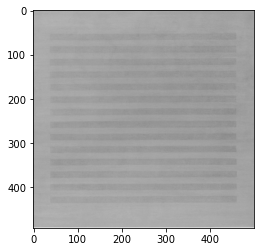

In [168]:
img = Image.open('Paintings/1983.008.png')
plt.imshow(img);

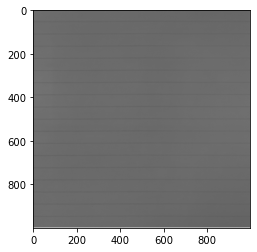

In [169]:
img = Image.open('Paintings/1989.018.png')
plt.imshow(img);

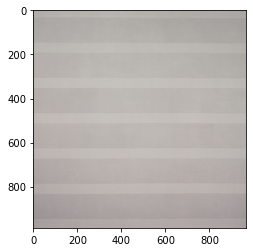

In [170]:
img = Image.open('Paintings/1990.006.png')
plt.imshow(img);

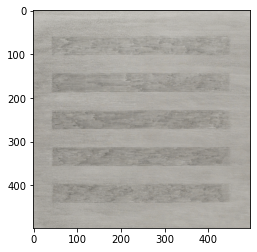

In [171]:
img = Image.open('Paintings/1983.003.png')
plt.imshow(img);